QUESTION 5.

In [ ]:
import tensorflow as tf

class Histogram(tf.keras.layers.Layer):
    def __init__(self, a, b, n):
        super(Histogram, self).__init__()
        self.a = tf.cast(a, dtype=tf.float32)
        self.b = tf.cast(b, dtype=tf.float32)
        self.n = n
        self.delta = (self.b - self.a) / (n - 1)

    def call(self, inputs):

        inputs = tf.cast(inputs, dtype=tf.float32)
        bin_edges = tf.linspace(self.a, self.b, self.n + 1)
        bin_indexes = tf.histogram_fixed_width_bins(inputs, bin_edges[:-1], nbins=self.n)

        # Count occurrences in each bin
        return tf.math.unsorted_segment_sum(tf.ones_like(inputs), bin_indexes, self.n)

#Test
def test_histogram():
    a = 0
    b = 10
    n = 5
    x = tf.constant([0.5, 1.5, 2.1, 2.5, 3.0, 5.5, 9.9, 6.0, 2.0, 3.5, 7.5, 8.0], dtype=tf.float32)

    hist_layer = Histogram(a, b, n)
    histogram_counts = hist_layer(x)
    print("Histogram counts:", histogram_counts.numpy())

test_histogram()


Histogram counts: [ 0.  1.  0.  1. 10.]


In [ ]:
def test_histogram():
    # Define test cases
    test_cases = [
        (tf.constant([0.5, 1.5, 2.1, 2.5, 3.0, 5.5, 9.9]), 0, 10, 5, "Standard mixed values"),
        (tf.constant([1, 1, 1, 1]), 0, 10, 5, "All values in one bin"),
        (tf.constant([]), 0, 10, 5, "Empty input"),
        (tf.constant([-2, -1, 0, 1, 2]), -2, 2, 5, "Negative and positive values"),
        (tf.constant([0, 2.5, 5, 7.5, 10]), 0, 10, 5, "Values exactly on bin edges")
    ]

    for inputs, a, b, n, description in test_cases:
        hist_layer = Histogram(a, b, n)
        histogram_counts = hist_layer(inputs)
        print(f"Test: {description}")
        print(f"Histogram counts: {histogram_counts.numpy()}\n")

# Run the test function
test_histogram()

Test: Standard mixed values
Histogram counts: [0. 1. 0. 1. 5.]

Test: All values in one bin
Histogram counts: [0. 0. 4. 0. 0.]

Test: Empty input
Histogram counts: [0. 0. 0. 0. 0.]

Test: Negative and positive values
Histogram counts: [1. 0. 0. 0. 4.]

Test: Values exactly on bin edges
Histogram counts: [1. 0. 0. 0. 4.]



QUESTION 7

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 572, 572, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 570, 570, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 568, 568, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 284, 284, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

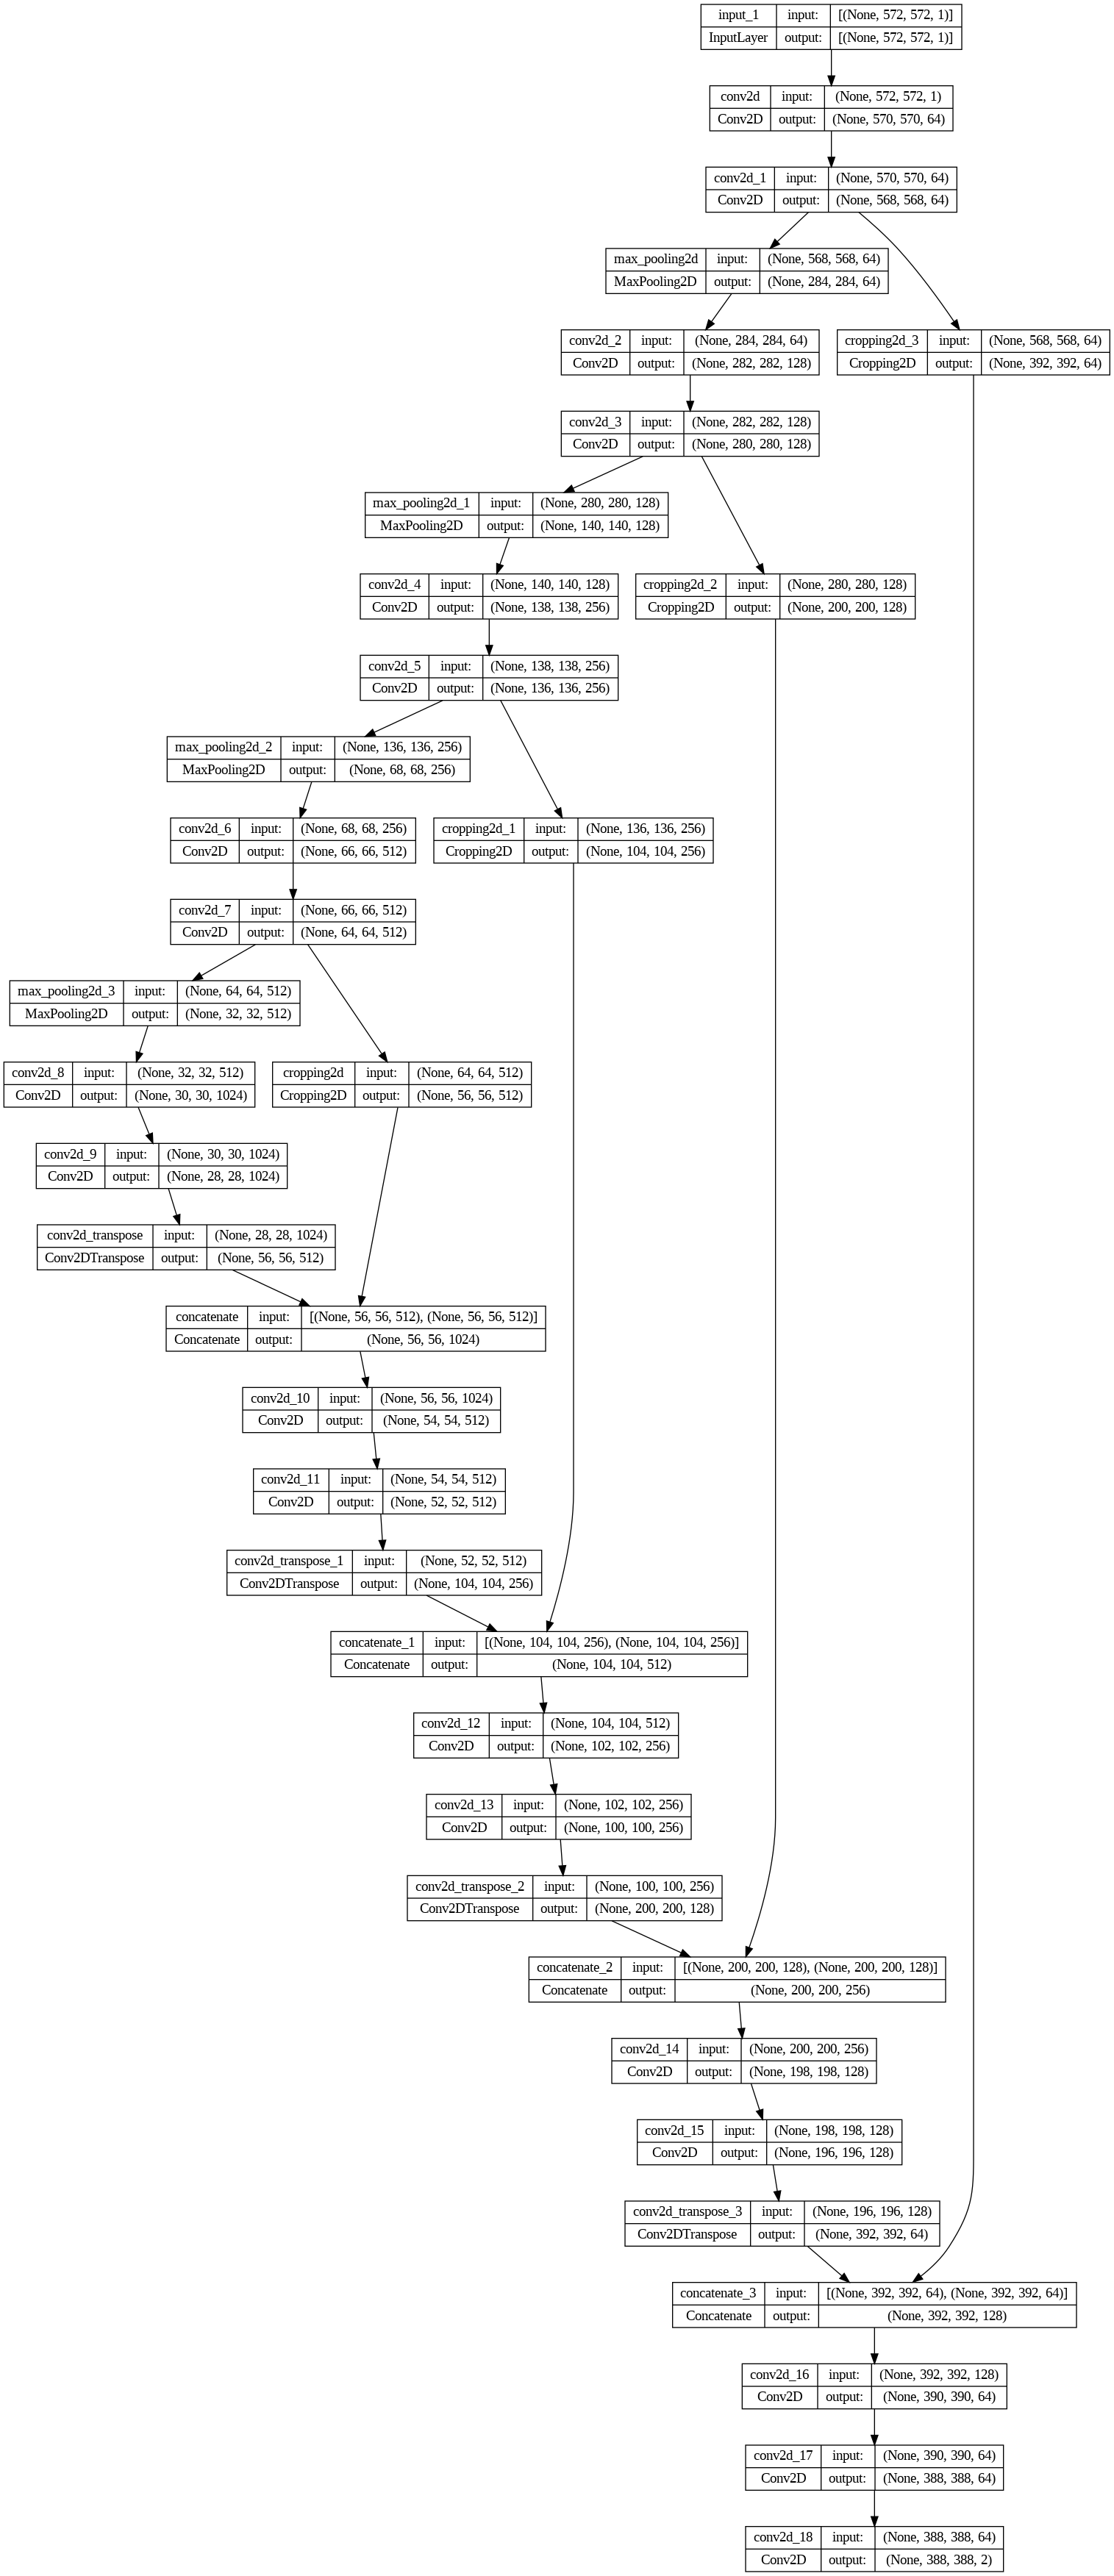

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D
from tensorflow.keras.utils import plot_model
def unet(input_size=(572, 572, 1)):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='valid')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='valid')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='valid')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='valid')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='valid')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='valid')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='valid')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='valid')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='valid')(c5)
    c4 = Cropping2D(cropping=(4, 4))(c4)  # Crop c4 to match u6's shape
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='valid')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='valid')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid')(c6)
    c3 = Cropping2D(cropping=(16, 16))(c3)  # Crop c3 to match u7's shape
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='valid')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='valid')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid')(c7)
    c2 = Cropping2D(cropping=(40, 40))(c2)  # Crop c2 to match u8's shape
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='valid')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='valid')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid')(c8)
    c1 = Cropping2D(cropping=(88, 88))(c1)  # Crop c1 to match u9's shape
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='valid')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='valid')(c9)

    outputs = Conv2D(2, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create the U-Net model
unet_model = unet()
unet_model.summary()

# Plot the model
plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)



QUESTION 6

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 U (InputLayer)              [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 784)                  615440    ['U[0][0]']                   
                                                                                                  
 multiply (Multiply)         (None, 784)                  0         ['U[0][0]',                   
                                                                     'dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 784)                  615440    ['U[0][0]']               

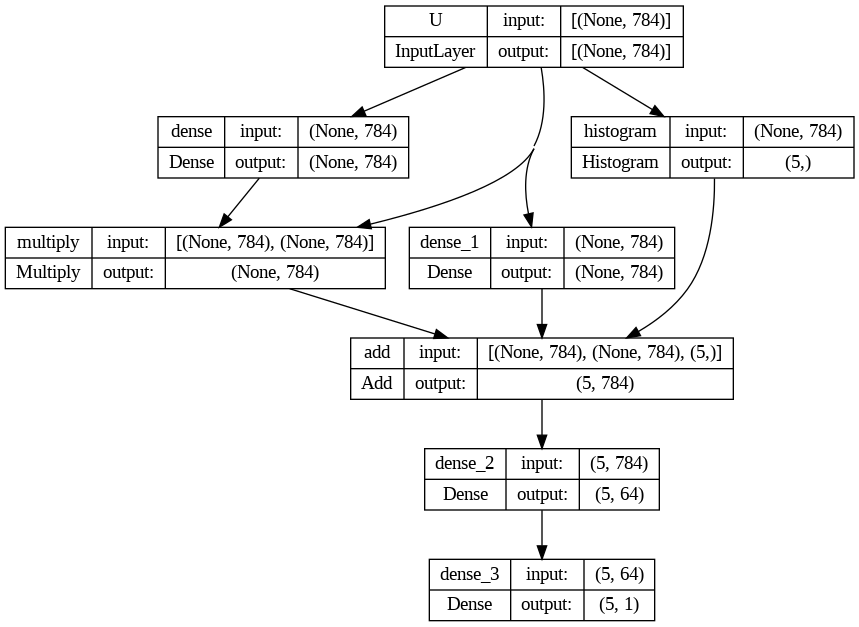

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add, Multiply, Activation, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

class Histogram(tf.keras.layers.Layer):
    def __init__(self, a, b, n):
        super(Histogram, self).__init__()
        self.a = tf.cast(a, dtype=tf.float32)  # Ensuring the type is tf.float32
        self.b = tf.cast(b, dtype=tf.float32)  # Ensuring the type is tf.float32
        self.n = n
        self.delta = (self.b - self.a) / (n - 1)

    def call(self, inputs):
        # Ensure input is also in float32 for compatibility
        inputs = tf.cast(inputs, dtype=tf.float32)
        # Determine the edges of the bins
        bin_edges = tf.linspace(self.a, self.b, self.n + 1)
        # Compute the histogram
        bin_indexes = tf.histogram_fixed_width_bins(inputs, bin_edges[:-1], nbins=self.n)
        # Count occurrences in each bin
        return tf.math.unsorted_segment_sum(tf.ones_like(inputs), bin_indexes, self.n)

# Define the input
input_u = Input(shape=(784,), name='U')

# Pathways
path_1 = input_u  # (1) U directly
histogram_output = Histogram(a=0, b=10, n=5)(input_u)  # (3) Histogram

# Assuming some transformations for (2) U and (4) U
path_2 = Dense(784, activation='relu')(input_u)
path_4 = Dense(784, activation='relu')(input_u)

# Combine the outputs
emul_output = Multiply()([path_1, path_2])  # Element-wise multiplication
combined_output = Add()([emul_output, path_4, histogram_output])  # Add for BSSum

# Further processing
dense_output = Dense(64, activation='relu')(combined_output)
final_output = Dense(1, activation='sigmoid')(dense_output)

# Create model
model = Model(inputs=input_u, outputs=final_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model structure
model.summary()
plot_model(model, to_file='modified_network.png', show_shapes=True, show_layer_names=True)
